Exploration of CNN Architectures

1. LeNet-5
2. AlexNet
3. VGG-16
4. ResNet18

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch.autograd as autograd
import torchtext
import torchvision.transforms as transforms
import torchdata.datapipes as dp
from torchdata.datapipes.iter import IterableWrapper, IterDataPipe
import torch.optim as optim
from torchinfo import summary
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.has_mps else "cpu")
# device = torch.device("cpu")
device

device(type='mps')

In [19]:
# function for training one epoch

def train_one_epoch(net, train_loader, criterion, optimizer):
    """
    Train the network for one epoch on device
    Prints the loss as well as  accuracy every 50 batches
    returns total loss and accuracy
    """
    net.train()
    total_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device = device), target.to(device= device)
        output = net(data).to(device = device)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct_batch = torch.sum(torch.max(output, 1)[1] == target).item()
        correct += correct_batch
        if batch_idx % 300 == 0:
            print('Train batch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} \taccuracy {}/{} ({:.0f}%)'.format(
                batch_idx, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(),
                correct_batch, len(data),
                100. * correct_batch / (len(data))))
    total_loss /= len(train_loader.dataset)
    print('Train Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format( total_loss, correct, len(train_loader.dataset),
                100. * correct / len(train_loader.dataset)))
    return total_loss, correct / len(train_loader.dataset)


# validation function
def validate(net, val_loader, criterion):
    """
    Validate the network
    Prints the loss as well as  accuracy.
    Returns total loss and accuracy
    """
    net.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = net(data).to(device)
            total_loss += criterion(output, target).item()  # sum up batch loss
            correct += torch.sum(torch.max(output, 1)[1] == target).item()
    total_loss /= len(val_loader.dataset)
    print('Validation Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format( total_loss, correct, len(val_loader.dataset),100. * correct / len(val_loader.dataset)))
    return total_loss, correct/len(val_loader.dataset)


# function to train the network for n epochs and validate after each epoch

def train(net, train_loader, val_loader, criterion, optimizer, n_epochs):
    """
    Train the network for n epochs and validate after each epoch.
    Store the loss and accuracy for each epoch and return them
    """
    # print the device used as well as specifications of the device
    print('Training on device: {}'.format(device))
    print('Training for {} epochs'.format(n_epochs))

    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    for epoch in range(n_epochs):
        print('Epoch {}/{}'.format(epoch, n_epochs - 1))
        print('-' * 10)
        epoch_train_loss,epoch_acc = train_one_epoch(net, train_loader, criterion, optimizer)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_acc)
        epoch_val_loss,epoch_val_acc = validate(net, val_loader, criterion)
        val_loss.append(epoch_val_loss)
        val_acc.append(epoch_val_acc)
        print()
    return train_loss, train_acc, val_loss, val_acc    

In [3]:
# import CIFAR10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../../pytorch_learning/data',
                                                train=True,
                                                transform=torchvision.transforms.ToTensor(),
                                                download=False)

test_dataset = torchvision.datasets.CIFAR10(root='../../../pytorch_learning/data',
                                            train=False,
                                            transform=torchvision.transforms.ToTensor(),
                                            download=False)
                                        

In [20]:

# Build a data loader
train_loader = DataLoader(dataset=train_dataset,
                                                batch_size=14,  # batch size    
                                                shuffle=True)  # shuffle the data


test_loader = DataLoader(dataset=test_dataset,
                                                batch_size=14,  # batch size
                                                shuffle=False)  # shuffle the data                                                



torch.Size([14, 3, 32, 32]) torch.Size([14])


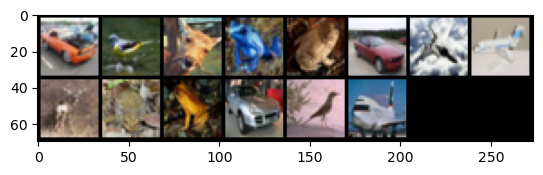

automobile  bird  deer  frog


In [21]:
# quick look at the data

# look at one random sample
dataiter = iter(train_loader)
data = next(dataiter)
inputs, targets = data
print(inputs.shape, targets.shape)

# plot a random sample
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(inputs))
# print labels
print(' '.join('%5s' % train_dataset.classes[targets[j]] for j in range(4)))

In [22]:
#LENET
class LeNet(nn.Module):
    """  
    LeNet is a simple convolutional neural network with two convolutional layers.
    It was introduced by Yann LeCun in 1998.
    """
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16,120,5)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(120,64)
        self.fc2 = nn.Linear(64,10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = self.flat(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x # no softmax. CrossEntropyLoss() does that for us. 10 classes


In [23]:
model = LeNet().to(device)

In [24]:
summary(copy.deepcopy(model), input_size=(1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─MaxPool2d: 1-2                         [1, 6, 14, 14]            --
├─Conv2d: 1-3                            [1, 16, 10, 10]           2,416
├─MaxPool2d: 1-4                         [1, 16, 5, 5]             --
├─Conv2d: 1-5                            [1, 120, 1, 1]            48,120
├─Flatten: 1-6                           [1, 120]                  --
├─Linear: 1-7                            [1, 64]                   7,744
├─Linear: 1-8                            [1, 10]                   650
Total params: 59,386
Trainable params: 59,386
Non-trainable params: 0
Total mult-adds (M): 0.66
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.30

In [13]:

# number of parameters verification

# 6 filters of size 5x5 + 6 bias terms on 3 channels
print(6*3*5*5+6)

# 16 filters of size 5x5 + 16 bias terms on 6 channels
print(16*6*5*5+16)

# 120 = 16*5*5
print(16*5*5)

456
2416
400


In [26]:
num_epochs = 10

# Loss and optimizer
criterion = nn.CrossEntropyLoss() # This already applies softmax
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train the network
train_loss, train_acc, val_loss, val_acc = train(model, train_loader, test_loader, criterion, optimizer, num_epochs)

Training on device: mps
Training for 10 epochs
Epoch 0/9
----------
Train batch: 0 [0/50000 (0%)]	Loss: 0.750396 	accuracy 10/14 (71%)
Train batch: 300 [4200/50000 (8%)]	Loss: 1.628818 	accuracy 7/14 (50%)
Train batch: 600 [8400/50000 (17%)]	Loss: 1.296912 	accuracy 9/14 (64%)
Train batch: 900 [12600/50000 (25%)]	Loss: 0.990214 	accuracy 8/14 (57%)
Train batch: 1200 [16800/50000 (34%)]	Loss: 1.400018 	accuracy 5/14 (36%)
Train batch: 1500 [21000/50000 (42%)]	Loss: 1.362286 	accuracy 9/14 (64%)
Train batch: 1800 [25200/50000 (50%)]	Loss: 1.550289 	accuracy 6/14 (43%)
Train batch: 2100 [29400/50000 (59%)]	Loss: 1.011050 	accuracy 7/14 (50%)
Train batch: 2400 [33600/50000 (67%)]	Loss: 1.155901 	accuracy 9/14 (64%)
Train batch: 2700 [37800/50000 (76%)]	Loss: 1.027441 	accuracy 7/14 (50%)
Train batch: 3000 [42000/50000 (84%)]	Loss: 1.043634 	accuracy 9/14 (64%)
Train batch: 3300 [46200/50000 (92%)]	Loss: 1.630339 	accuracy 2/14 (14%)
Train Average loss: 0.0905, Accuracy: 27228/50000 (54%)



##### Next: Lets try some pretrained models like VGG-16, GoogLeNet, ResNet-50

In [63]:
mean = 0.
std = 0.
for images, _ in train_loader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(train_loader.dataset)
std /= len(train_loader.dataset)
print(mean, std)

tensor([0.4914, 0.4822, 0.4465]) tensor([0.2023, 0.1994, 0.2010])


In [64]:
# TO apply VGG, we need to normalize the data like this
std_normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                          std=[0.2023, 0.1994, 0.2010])
trans = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(), 
        std_normalize])


train_dataset = torchvision.datasets.CIFAR10(root='../../../pytorch_learning/data',
                                                train=True,
                                                transform=trans,
                                                download=False)

test_dataset = torchvision.datasets.CIFAR10(root='../../../pytorch_learning/data',
                                                train=False,
                                                transform=trans,
                                                download=False)

# Build a data loader
train_loader = DataLoader(dataset=train_dataset,
                                                batch_size=14,  # batch size
                                                shuffle=True)  # shuffle the data


test_loader = DataLoader(dataset=test_dataset,
                                                batch_size=14,  # batch size
                                                shuffle=False)  # shuffle the data                                                

#### VGG-16

VGG-16 is a convolutional neural network architecture named after the Visual Geometry Group from the University of Oxford. It is a 16-layer deep neural network that is trained on more than a million images from the ImageNet database. The network is 16 layers deep because it contains 13 convolutional layers, where each convolutional layer is followed by a ReLU non-linearity and a 2×2 max-pooling operation with a stride of 2. The architecture of the network is illustrated in the figure below.

While all previous iterations of CNN models believed in the idea of bigger receptive fields (for example, AlexNet had 11 x 11 convolution kernels), VGG proposed the idea of breaking all of these down to just 3 x 3 convolutions. According to the VGG architecture, multiple 3 x 3 convolutions stacked together are capable of replicating bigger receptive fields and with more nonlinearities present in between them (in terms of activation functions), it can even perform better than their counterparts with bigger receptive fields. They even introduced 1*1 convolutions in order to further increase the nonlinearity present in the model. VGG models have become quite famous since then and are used even today in various tutorials to introduce newcomers to CNNs.

In [78]:
### VGG16

## import pretrained model VGG16 from torchvision.models
vgg = torchvision.models.vgg16(pretrained=True)

# print the model
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [79]:
# Train everything except the last layer
for param in vgg.parameters():
    param.requires_grad = False

# replace the last layer
vgg.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 10),
)

# print the model
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [80]:
vgg.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=1024, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=1024, out_features=10, bias=True)
)

In [81]:
# lets check the number of parameters which are trainable
params_to_update = []
for name,param in vgg.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

# only last layer is trainable as we have set requires_grad = False for all other layers

	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


In [82]:
# quick eval on a random sample
dataiter = iter(train_loader)
data = next(dataiter)
inputs, targets = data
print(inputs.shape, targets.shape)

vgg.eval()
outputs = vgg(inputs)
print(outputs.shape)

# print the first 5 predictions
print(outputs[:5])
# argmax
print(torch.max(outputs, 1)[1])

torch.Size([14, 3, 224, 224]) torch.Size([14])
torch.Size([14, 10])
tensor([[-0.0162,  0.0061, -0.0304,  0.0828,  0.0819, -0.0306, -0.0255, -0.0116,
         -0.0626, -0.0254],
        [-0.0582,  0.0273,  0.0532,  0.0633,  0.0650, -0.0419, -0.0077,  0.0140,
         -0.1102, -0.0029],
        [-0.0241,  0.0480,  0.0330,  0.0220,  0.1092, -0.0122,  0.0205,  0.0251,
          0.0070, -0.0286],
        [ 0.0228,  0.0143,  0.0443,  0.0659,  0.1031, -0.0477, -0.0093,  0.0386,
         -0.0689,  0.0254],
        [-0.0006,  0.0949, -0.0064, -0.0252,  0.0249, -0.0512,  0.0205,  0.0245,
         -0.0375, -0.0820]], grad_fn=<SliceBackward0>)
tensor([3, 4, 4, 4, 1, 1, 4, 1, 1, 4, 4, 7, 7, 1])


In [83]:
num_epochs = 1
# Loss and optimizer
criterion = nn.CrossEntropyLoss() # This already applies softmax as output is logits
optimizer = optim.Adam(vgg.parameters(), lr=0.001)

vgg = vgg.to(device)
# train the network
train_loss, train_acc, val_loss, val_acc = train(vgg, train_loader, test_loader, criterion, optimizer, num_epochs)

Training on device: mps
Training for 1 epochs
Epoch 0/0
----------
Train batch: 0 [0/50000 (0%)]	Loss: 2.305223 	accuracy 1/14 (7%)
Train batch: 300 [4200/50000 (8%)]	Loss: 0.727921 	accuracy 10/14 (71%)
Train batch: 600 [8400/50000 (17%)]	Loss: 1.201770 	accuracy 10/14 (71%)
Train batch: 900 [12600/50000 (25%)]	Loss: 1.108122 	accuracy 9/14 (64%)
Train batch: 1200 [16800/50000 (34%)]	Loss: 0.638799 	accuracy 11/14 (79%)
Train batch: 1500 [21000/50000 (42%)]	Loss: 0.268450 	accuracy 13/14 (93%)
Train batch: 1800 [25200/50000 (50%)]	Loss: 0.502376 	accuracy 11/14 (79%)
Train batch: 2100 [29400/50000 (59%)]	Loss: 0.186778 	accuracy 12/14 (86%)
Train batch: 2400 [33600/50000 (67%)]	Loss: 0.850882 	accuracy 9/14 (64%)
Train batch: 2700 [37800/50000 (76%)]	Loss: 0.319600 	accuracy 13/14 (93%)
Train batch: 3000 [42000/50000 (84%)]	Loss: 0.382060 	accuracy 11/14 (79%)
Train batch: 3300 [46200/50000 (92%)]	Loss: 0.543647 	accuracy 11/14 (79%)
Train Average loss: 0.0674, Accuracy: 35880/50000 (

#### AlexNet

AlexNet is a convolutional neural network architecture that was used to win the ImageNet Large Scale Visual Recognition Challenge in 2012. The network was named after Alex Krizhevsky, the first author of the paper that introduced the architecture. 

The architecture consists of eight layers: five convolutional layers and three fully-connected layers

AlexNet was one of the first CNN models implemented on GPUs that truly connected the growing computation power at that time with deep learning. They created a deeper and more complex CNN model that had kernels of various sizes (like 11  x 11, 5 x5, and 3x 3) and significantly more number of channels than LeNet. They also started using ReLU activations instead of sigmoid or tanh, which helped train better models. 

ImageNet: a dataset made of more than 15 million high-resolution images labeled with 22 thousand classes

In [71]:
# Next lets try AlexNet from torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

# print the model
print(alexnet)

/Users/raghavendrakommavarapu/opt/anaconda3/envs/torch_2_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [72]:
256 * 6 * 6

9216

In [73]:
# Train everything except the last layer
for param in alexnet.parameters():
    param.requires_grad = False

# replace the last layer
alexnet.classifier = nn.Sequential(
    nn.Linear(256 * 6 * 6, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(4096, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(1024, 10),
)

# print the model
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dro

In [74]:

# quick eval on a random sample
dataiter = iter(train_loader)
data = next(dataiter)
inputs, targets = data
print(inputs.shape, targets.shape)

alexnet.eval()
outputs = alexnet(inputs)
print(outputs.shape)

# print the first 5 predictions
print(outputs[:5])
# argmax
print(torch.max(outputs, 1)[1])

torch.Size([14, 3, 224, 224]) torch.Size([14])
torch.Size([14, 10])
tensor([[-0.0324,  0.1576, -0.0120,  0.0930,  0.0179, -0.0277,  0.0172, -0.2346,
          0.0124,  0.0291],
        [-0.0053,  0.2142,  0.0114,  0.2148,  0.0085,  0.0541, -0.1131, -0.1068,
          0.0665,  0.0549],
        [-0.0332,  0.1187, -0.0019,  0.0449,  0.0313,  0.0679, -0.0776, -0.1707,
          0.0557,  0.0439],
        [ 0.0489,  0.2040,  0.0508,  0.0490, -0.0563, -0.1323, -0.0087, -0.2425,
          0.0059, -0.0331],
        [-0.0787,  0.2335,  0.1165,  0.1603, -0.0307, -0.0884, -0.0287, -0.1549,
          0.0934,  0.1709]], grad_fn=<SliceBackward0>)
tensor([1, 3, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 3, 8])


In [76]:
num_epochs = 1

# Loss and optimizer
criterion = nn.CrossEntropyLoss() # This already applies softmax as output is logits
optimizer = optim.Adam(alexnet.parameters(), lr=0.001)

alexnet = alexnet.to(device)
# train the network
train_loss, train_acc, val_loss, val_acc = train(alexnet, train_loader, test_loader, criterion, optimizer, num_epochs)

Training on device: mps
Training for 1 epochs
Epoch 0/0
----------
Train batch: 0 [0/50000 (0%)]	Loss: 2.342678 	accuracy 1/14 (7%)
Train batch: 300 [4200/50000 (8%)]	Loss: 1.331199 	accuracy 8/14 (57%)
Train batch: 600 [8400/50000 (17%)]	Loss: 1.488607 	accuracy 8/14 (57%)
Train batch: 900 [12600/50000 (25%)]	Loss: 1.660999 	accuracy 9/14 (64%)
Train batch: 1200 [16800/50000 (34%)]	Loss: 0.750136 	accuracy 9/14 (64%)
Train batch: 1500 [21000/50000 (42%)]	Loss: 2.307770 	accuracy 6/14 (43%)
Train batch: 1800 [25200/50000 (50%)]	Loss: 0.863540 	accuracy 9/14 (64%)
Train batch: 2100 [29400/50000 (59%)]	Loss: 0.614939 	accuracy 11/14 (79%)
Train batch: 2400 [33600/50000 (67%)]	Loss: 1.553318 	accuracy 10/14 (71%)
Train batch: 2700 [37800/50000 (76%)]	Loss: 1.070354 	accuracy 10/14 (71%)
Train batch: 3000 [42000/50000 (84%)]	Loss: 0.214928 	accuracy 13/14 (93%)
Train batch: 3300 [46200/50000 (92%)]	Loss: 1.047740 	accuracy 8/14 (57%)
Train Average loss: 0.0787, Accuracy: 32621/50000 (65%)


#### ResNet

ResNet is a convolutional neural network architecture that was used to win the ImageNet Large Scale Visual Recognition Challenge in 2015. The network was named after Kaiming He, the first author of the paper that introduced the architecture.

ResNet-50 is a 50-layer convolutional neural network (48 convolutional layers, one MaxPool layer, and one average pool layer). Residual neural networks are a type of artificial neural network (ANN) that forms networks by stacking residual blocks.It provided a novel way to add more convolutional layers to a CNN, without running into the vanishing gradient problem, using the concept of shortcut connections. A shortcut connection “skips over” some layers, converting a regular network to a residual network. The ResNet architecture follows two basic design rules. First, the number of filters in each layer is the same depending on the size of the output feature map. Second, if the feature map’s size is halved, it has double the number of filters to maintain the time complexity of each layer.

Resnet18 is a 18-layer deep residual network. It is a convolutional neural network that is 18 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals.

In [89]:
# Next lets try ResNet18 from torchvision.models

resnet = torchvision.models.resnet18(pretrained=True)

# print the model
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [90]:

# Train everything except the last layer
for param in resnet.parameters():
    param.requires_grad = False
    
# replace the last layer
resnet.fc = nn.Sequential(
    nn.Linear(512, 10),
)

# perform xaiver initialization for the last layer
nn.init.xavier_uniform_(resnet.fc[0].weight)

# print the model
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [91]:
# quick eval on a random sample
dataiter = iter(train_loader)
data = next(dataiter)
inputs, targets = data
print(inputs.shape, targets.shape)

resnet.eval()
outputs = resnet(inputs)
print(outputs.shape)

# print the first 5 predictions
print(outputs[:5])
# argmax
print(torch.max(outputs, 1)[1])

torch.Size([14, 3, 224, 224]) torch.Size([14])
torch.Size([14, 10])
tensor([[-1.7678, -0.9300,  2.3200,  2.1771, -1.0256,  1.9731, -0.2456, -0.4061,
          1.9226,  0.1099],
        [-4.7263, -0.1636,  2.4042,  1.2686, -1.1421,  0.9737, -0.3888, -0.0875,
          0.5457, -1.0090],
        [-2.7763, -2.5563,  2.5890,  1.2486,  0.3011,  2.2185,  0.1753,  0.2914,
          1.8927,  0.8021],
        [-3.2918, -0.9196,  2.3658,  0.4952,  0.3495,  1.2475, -0.0300, -0.0193,
          3.9423,  1.0960],
        [-2.0476, -0.2162,  0.5544,  1.2181,  0.7139,  1.2176, -0.3056,  0.5520,
          2.9176, -1.0585]], grad_fn=<SliceBackward0>)
tensor([2, 2, 2, 8, 8, 4, 2, 5, 2, 8, 3, 3, 8, 3])


In [92]:
num_epochs = 1

# Loss and optimizer
criterion = nn.CrossEntropyLoss() # This already applies softmax as output is logits
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

resnet = resnet.to(device)
# train the network
train_loss, train_acc, val_loss, val_acc = train(resnet, train_loader, test_loader, criterion, optimizer, num_epochs)

Training on device: mps
Training for 1 epochs
Epoch 0/0
----------
Train batch: 0 [0/50000 (0%)]	Loss: 3.245783 	accuracy 2/14 (14%)
Train batch: 300 [4200/50000 (8%)]	Loss: 1.180311 	accuracy 10/14 (71%)
Train batch: 600 [8400/50000 (17%)]	Loss: 1.278763 	accuracy 9/14 (64%)
Train batch: 900 [12600/50000 (25%)]	Loss: 0.686409 	accuracy 11/14 (79%)
Train batch: 1200 [16800/50000 (34%)]	Loss: 1.341921 	accuracy 6/14 (43%)
Train batch: 1500 [21000/50000 (42%)]	Loss: 0.780695 	accuracy 9/14 (64%)
Train batch: 1800 [25200/50000 (50%)]	Loss: 0.912750 	accuracy 10/14 (71%)
Train batch: 2100 [29400/50000 (59%)]	Loss: 1.078136 	accuracy 9/14 (64%)
Train batch: 2400 [33600/50000 (67%)]	Loss: 1.469790 	accuracy 7/14 (50%)
Train batch: 2700 [37800/50000 (76%)]	Loss: 1.117454 	accuracy 10/14 (71%)
Train batch: 3000 [42000/50000 (84%)]	Loss: 0.522645 	accuracy 13/14 (93%)
Train batch: 3300 [46200/50000 (92%)]	Loss: 0.503953 	accuracy 12/14 (86%)
Train Average loss: 0.0690, Accuracy: 33394/50000 (67